In [3]:
#libraries to import
from os import listdir
from tqdm import tqdm
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential


In [ ]:
# function to extract features from each photo in the directory
def extract_features(directory):
    # load the VGG16 model
    model = Sequential()
    vgg_16 = VGG16()

    # Print the model summary to understand the model
    print(vgg_16.summary())

    # re-structure the model by removing the last layer
    #####

    for layer in vgg_16.layers[:-1]: 
        model.add(layer)

    # summarize
    print(model.summary())

    # extract features from each photo in a dictionary
    features = dict()

    # iterate over all the files of the dataset directory
    for name in listdir(directory):

        filename = directory + '/' + name
        # load the image from filename with target size of (224,224)
        image = load_img(filename,  target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model (1, 3, 224, 224)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # preprocess the image for the VGG model	
        image = preprocess_input(image)

        # get features (output of the model for the image)
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature in the features dictionary with image_id as key and feature as value
        features[image_id] = feature

    return features

# extract features from all images
directory = 'Flicker8k_Dataset/'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features2.pkl', 'wb'))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
#this is the output to understand the feature dictionary variable.

i = 0
for key, value in features.items():
    print("key: ", key, "value: ", value)
    i += 1
    if i==9:
        break

print(value.shape)
print(len(features))

key:  1000268201_693b08cb0e value:  [[2.5076463 0.        0.        ... 0.        0.        0.       ]]
key:  1001773457_577c3a7d70 value:  [[0.        0.        0.4941088 ... 0.        0.        0.       ]]
key:  1002674143_1b742ab4b8 value:  [[1.4937083  0.         0.53568405 ... 2.3154142  3.7418432  0.        ]]
key:  1003163366_44323f5815 value:  [[0. 0. 0. ... 0. 0. 0.]]
key:  1007129816_e794419615 value:  [[0.         0.09227604 0.         ... 0.         0.         0.06529218]]
key:  1007320043_627395c3d8 value:  [[0.        0.        0.        ... 0.        3.3386385 0.       ]]
key:  1009434119_febe49276a value:  [[2.0962937  2.1193173  3.5624375  ... 0.64264333 2.714653   0.        ]]
key:  1012212859_01547e3f17 value:  [[0.        0.        0.9873686 ... 0.        1.4932499 0.8612866]]
key:  1015118661_980735411b value:  [[1.4410408 0.2829206 0.        ... 0.        2.4591966 0.       ]]
(1, 4096)
8091


# Preparing the text data

In [7]:
import string

#load doc into memory

def load_doc(filname):
    file = open(filname, 'r')
    text = file.read()
    file.close()
    return text

In [9]:
doc = load_doc("Flickr8k.token.txt")

In [10]:
filename = doc.split("\n")[0].split("\t")[0].split(".")[0]
descript = doc.split("\n")[0].split("\t")[1]

In [11]:
print(filename)
print(descript)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [12]:
line1 = doc.split('\n')[0]
line1 = line1.split()
img_id = line1[0]
img_desc = line1[1:]
img_desc = ' '.join(img_desc)

print(img_id[:-2])
print(img_desc)

1000268201_693b08cb0e.jpg
A child in a pink dress is climbing up a set of stairs in an entry way .


In [13]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0][:-2], tokens[1:]

        # remove filename from image id
        image_id = image_id.split('.')[0]

        # convert description tokens back to string
        image_desc = ' '.join(image_desc)

        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()

        # store description
        mapping[image_id].append(image_desc)

    return mapping

In [14]:
# We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

# 1. Convert all words to lowercase.
# 2. Remove all punctuation.
# 3. Remove all words that are one character or less in length (e.g. ‘a’).
# 4. Remove all words with numbers in them.

def clean_descriptions(descriptions):

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]

            # tokenize desc using split 
            desc = desc.split()

            # convert all the words in desc to lower case
            desc = [word.lower() for word in desc]

            # remove punctuation from each token using translate function 
            # pass the "table" variable to this function
            desc = [word.translate(table) for word in desc ]

            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]

            # remove tokens with numbers in them using isalpha
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [15]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):

    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [16]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [18]:
# Use the above functions in the code below-

filename = 'Flickr8k.token.txt'

# load descriptions (pass the filename)
doc = load_doc(filename)

# parse descriptions (pass doc)
descriptions = load_descriptions(doc) 
print('Loaded: %d ' % len(descriptions))

# clean the descriptions
#####
clean_descriptions(descriptions)

# summarize descriptions to a vocabulary of words
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, 'descriptions2.txt')

# You should get the following output for the above code

Loaded: 8092 
Vocabulary Size: 8763


# load deep learning model

In [4]:
from numpy import array
from pickle import load, dump
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

    # fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [21]:
# REFERENCE CODE
# X1, X2 (text sequence), y (word)
# photo	    startseq, little
# photo	    startseq  little, girl
# photo	    startseq  little  girl, running
# photo	    startseq  little  girl  running, in
# photo	    startseq  little  girl  running  in, field
# photo	    startseq, little, girl, running, in, field,     endseq

# You need to create the sequences in abovee format for your data

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [27]:
from tensorflow.keras.models import load_model

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    # define an input of shape (4096,)
    inputs1 = Input(shape=(4096,))
    # Add a dropout layer of 0.5
    fe1 = Dropout(0.5)(inputs1)
    # Add a dense layer of 256 units with relu activation
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    # Define input of shape (max_length,)
    inputs2 = Input(shape=(max_length,))
    # Define an 256 dimension embedding layer with the vocab_size and parameter mark_zero=True
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    # Add a dropout layer of 0.5
    se2 = Dropout(0.5)(se1)
    # Add LSTM Layer
    se3 = LSTM(256)(se2)

    # decoder model
    # Add the outputs of feature extractor model and sequence model
    decoder1 = Add()([fe2, se3])
    # Feed it to a dense layer of 256 units with relu activation
    decoder2 = Dense(256, activation='relu')(decoder1)
    # Add a dense layer with no. of units=vocab_size, and softmax activation
    outputs = Dense(vocab_size, activation="softmax")(decoder2)

    # tie it together and create a model instance which takes input as [image, seq] and gives output as [word]  
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # compile model with categorical crossentropy loss and adam optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam")

    # summarize model
    model.summary()

    # check if this is same as image provided 
    try:
        plot_model(model, to_file='model.png', show_shapes=True)
    except:
        pass
    return model

# data generator, intended to be used in a call to model.fit()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            # create the sequences
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# load clean descriptions for train
train_descriptions = load_clean_descriptions('descriptions2.txt',train)
print('Descriptions: train=%d' % len(train_descriptions))

# load photo features for train using pkl file
train_features = load_photo_features('features2.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer for train descriptions
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length of train description
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 5
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch and verbose 1
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
model.save('model_' + str(i) + '.h5')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']        

# Model Evaluation

In [6]:
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.models import load_model
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence using texts_to_sequences (consider first element)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequence for maxlength
        sequence =  pad_sequences([sequence], maxlen=max_length)
        # predict next word using both photo and sequence
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat =  argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    # assign empty lists
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare tokenizer on train set

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# load clean descriptions for train
train_descriptions = load_clean_descriptions('descriptions2.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer for train descriptions
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length =  max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = 'Flickr_8k.trainImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions2.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features2.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = 'model_4.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

In [7]:
from numpy import argmax
from tensorflow.keras.models import load_model
from numpy import argmax
from tensorflow.keras.models import load_model

# extract features from each image in the directory
def extract_features(filename):
    model = Sequential()
    #load model
    vgg_16 = VGG16()
    # re-structure the model by removing the last layer
    for layer in vgg_16.layers[:-1]: # this is where I changed your code
        model.add(layer)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model_4.h5')
# load and prepare your own image to generate the caption
photo = extract_features('boyinstreet.jpeg')   
# generate description
description =  generate_desc(model, tokenizer, photo, max_length)

In [8]:
from IPython.display import Image

 man in black shirt and jeans is walking down the street 


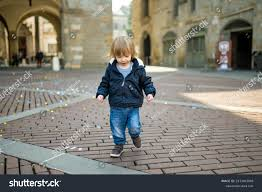

In [9]:
print(description[8:-6])
# print(description)
# provide your image file name 
Image(filename='boyinstreet.jpeg')